In [1]:
import os
import tarfile 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE 
from sklearn import model_selection

In [2]:
output_dir = "../results"
os.makedirs(output_dir, exist_ok=True)

In [3]:
with tarfile.open("data/visits.tar.xz", "r:xz") as tar:
    tar.extractall(path="data/extracted_data")
print(f"Files extracted to: {"data"}")

Files extracted to: data


In [4]:
data_frames = {}
for file_name in os.listdir("data/extracted_data/visits"):
    if file_name.endswith(".csv"):
        combined_df_name = os.path.splitext(file_name)[0]
        data_frames[combined_df_name] = pd.read_csv(os.path.join("data/extracted_data/visits", file_name))
        print(f"Loaded: {combined_df_name}")

Loaded: visit-1
Loaded: visit-2
Loaded: visit-3
Loaded: visit-4
Loaded: visit-5


In [6]:
data_frames

{'visit-1':       ID    MRI_ID  visit  delay sex hand  age  YOE  SES  MMSE        CDR  \
 0      1  0001_MR1      1      0   M    R   87   14  2.0    27       none   
 1      2  0002_MR1      1      0   M    R   75   12  NaN    23  very mild   
 2      4  0004_MR1      1      0   F    R   88   18  3.0    28       none   
 3      5  0005_MR1      1      0   M    R   80   12  4.0    28       none   
 4      7  0007_MR1      1      0   M    R   71   16  NaN    28  very mild   
 ..   ...       ...    ...    ...  ..  ...  ...  ...  ...   ...        ...   
 145  182  0182_MR1      1      0   M    R   73   12  NaN    23  very mild   
 146  183  0183_MR1      1      0   F    R   66   13  2.0    30       none   
 147  184  0184_MR1      1      0   F    R   72   16  3.0    24  very mild   
 148  185  0185_MR1      1      0   M    R   80   16  1.0    28  very mild   
 149  186  0186_MR1      1      0   F    R   61   13  2.0    30       none   
 
      eTIV   nWBV    ASF  
 0    1987  0.696  0.883

In [8]:
combined_df = pd.concat(data_frames.values(), ignore_index=True)
print("Combined DataFrame:")
combined_df

Combined DataFrame:


,ID,MRI_ID,visit,delay,sex,hand,age,YOE,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,0001_MR1,1,0,M,R,87,14,2.0,27.0,none,1987.0,0.696,0.883
1,2,0002_MR1,1,0,M,R,75,12,NaN,23.0,very mild,1678.0,0.736,1.046
2,4,0004_MR1,1,0,F,R,88,18,3.0,28.0,none,1215.0,0.710,1.444
3,5,0005_MR1,1,0,M,R,80,12,4.0,28.0,none,1689.0,0.712,1.039
4,7,0007_MR1,1,0,M,R,71,16,NaN,28.0,very mild,1357.0,0.748,1.293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,36,0036_MR5,5,2369,F,R,75,13,4.0,29.0,none,1349.0,0.778,1.301
369,48,0048_MR5,5,1233,M,R,69,16,1.0,4.0,mild,1701.0,0.676,1.032
370,70,0070_MR5,5,2386,M,R,86,17,1.0,30.0,none,1720.0,0.705,1.02
371,73,0073_MR5,5,2517,F,R,77,14,3.0,29.0,none,1504.0,0.769,1.167


In [11]:
combined_df["CDR"].isna().sum()

np.int64(0)

In [8]:
combined_df.columns

Index(['ID', 'MRI_ID', 'visit', 'delay', 'sex', 'hand', 'age', 'YOE', 'SES',
       'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')

In [9]:
missing_columns_report =[]
for column in combined_df.columns: 
     if combined_df[column].isna().sum() > 0: 
          missing_columns_report.append(column)

missing_columns_report

['SES', 'MMSE', 'eTIV', 'ASF']

In [9]:
new_missing = combined_df[combined_df["SES"].isna() == True]
new_missing

,ID,MRI_ID,visit,delay,sex,hand,age,YOE,SES,MMSE,CDR,eTIV,nWBV,ASF
1,2,0002_MR1,1,0,M,R,75,12,NaN,23.0,very mild,1678.0,0.736,1.046
4,7,0007_MR1,1,0,M,R,71,16,NaN,28.0,very mild,1357.0,0.748,1.293
52,63,0063_MR1,1,0,F,R,80,12,NaN,30.0,very mild,1430.0,0.737,1.228
81,99,0099_MR1,1,0,F,R,80,12,NaN,27.0,very mild,1475.0,0.762,1.19
94,114,0114_MR1,1,0,F,R,76,12,NaN,27.0,very mild,1316.0,0.727,1.333
130,160,0160_MR1,1,0,M,R,76,12,NaN,27.0,very mild,1557.0,0.705,1.127
144,181,0181_MR1,1,0,F,R,74,12,NaN,26.0,very mild,1171.0,0.733,1.499
145,182,0182_MR1,1,0,M,R,73,12,NaN,23.0,very mild,1661.0,0.698,1.056
151,2,0002_MR2,2,560,M,R,76,12,NaN,28.0,very mild,1738.0,0.713,1.01
198,63,0063_MR2,2,490,F,R,81,12,NaN,27.0,very mild,1453.0,0.721,1.208


In [10]:
#clean data 
expected_values_CDR_map = {'midl': "mild", 
                           'very miId' : 'very mild', 
                           'very midl' : 'very mild', 
                           'vry mild' : 'very mild'}
combined_df["CDR"] = combined_df['CDR'].map(expected_values_CDR_map).fillna(combined_df["CDR"])
set(combined_df["CDR"].values)


{'mild', 'moderate', 'none', 'very mild'}

In [11]:
set(combined_df["ASF"].values)
#convert data typoes: all into float 
set(combined_df["SES"].values)
#into categorical 


{np.float64(1.0),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(4.0),
 np.float64(5.0),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan)}

In [12]:
combined_df["sex"] = combined_df["sex"].replace({"M": 1, "F":0})

combined_df['sex'] = combined_df['sex'].astype('category')
combined_df['CDR'] = combined_df['CDR'].astype('category')
combined_df['ASF'] = pd.to_numeric(combined_df['ASF'], errors='coerce')
combined_df['ASF'] = combined_df['ASF'].replace(103.0, np.nan) #handling outlier

combined_df['ASF'] = combined_df['ASF'].fillna(combined_df['ASF'].median())
combined_df['SES'] = combined_df['SES'].fillna(combined_df['SES'].median())
combined_df['MMSE'] = combined_df['MMSE'].fillna(combined_df['MMSE'].mean())
combined_df['eTIV'] = combined_df['eTIV'].fillna(combined_df['eTIV'].mean())

cdr_order = ['none', 'very mild', 'mild', 'moderate', 'severe']
ses_order = [1, 2, 3, 4, 5]
combined_df['CDR'] = pd.Categorical(combined_df['CDR'], categories=cdr_order, ordered=True)
combined_df['SES'] = pd.Categorical(combined_df['SES'], categories=ses_order, ordered=True)

C:\Users\sanja\AppData\Local\Temp\ipykernel_2652\2760161187.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df["sex"] = combined_df["sex"].replace({"M": 1, "F":0})


In [14]:
combined_df.head()

,ID,MRI_ID,visit,delay,sex,hand,age,YOE,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,0001_MR1,1,0,1,R,87,14,2,27.0,none,1987.0,0.696,0.883
1,2,0002_MR1,1,0,1,R,75,12,2,23.0,very mild,1678.0,0.736,1.046
2,4,0004_MR1,1,0,0,R,88,18,3,28.0,none,1215.0,0.710,1.444
3,5,0005_MR1,1,0,1,R,80,12,4,28.0,none,1689.0,0.712,1.039
4,7,0007_MR1,1,0,1,R,71,16,2,28.0,very mild,1357.0,0.748,1.293


<function matplotlib.pyplot.show(close=None, block=None)>

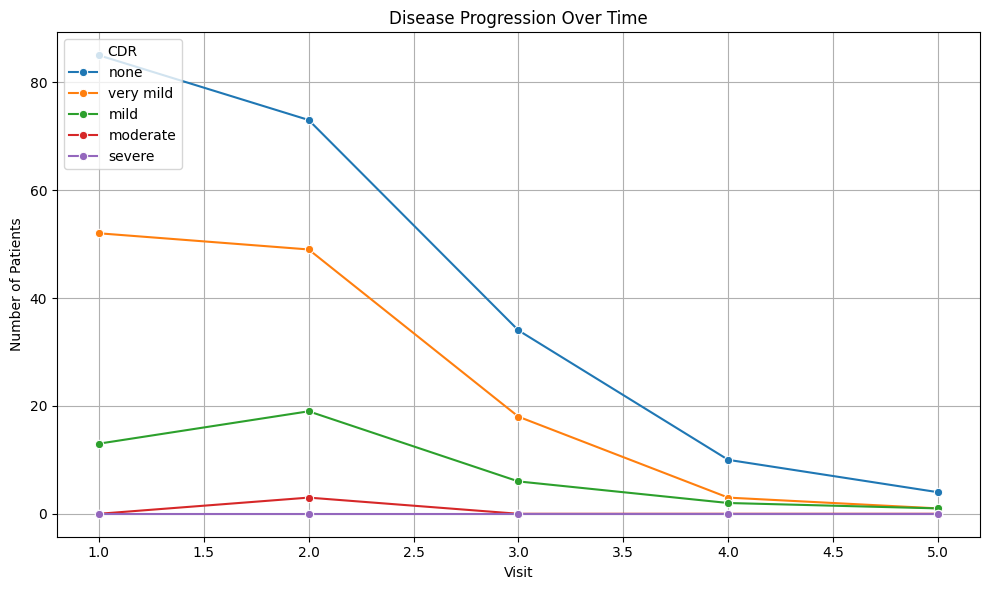

In [15]:
#fields to drop: MRI_ID and Hand
progression_data = combined_df.groupby(['visit', 'CDR'], observed=False).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.lineplot(data=progression_data, x='visit', y='count', hue="CDR", marker="o")
plt.title('Disease Progression Over Time')
plt.xlabel('Visit')
plt.ylabel('Number of Patients')
plt.legend(title='CDR', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show

Key Steps Explanation:

Numeric Conversion: The CDR column is converted from strings (e.g., 'none', 'very mild') to numbers (0.0, 0.5, etc.) to allow for mathematical comparison.

Baseline Extraction: We isolate the CDR score from the first visit (visit == 1) to serve as the reference point for each patient.

Comparison: We group the data by ID to find the maximum CDR score that patient ever recorded. If max_CDR > baseline_CDR, it means the patient's cognitive status declined at some point.

Broadcasting: The final calculated label (0 or 1) is merged back into the main dataframe. This means every row associated with a specific Patient ID will carry the same label, indicating if that patient eventually worsened.

In [13]:
# 2. Function to map CDR text to numeric scale
def parse_cdr(val):
    mapping = {
        'none': 0.0,
        'very mild': 0.5,
        'mild': 1.0,
        'moderate': 2.0,
        'severe': 3.0
    }
    return mapping.get(str(val).lower(), np.nan)

combined_df['CDR_numeric'] = combined_df['CDR'].apply(parse_cdr)
baseline_cdr = combined_df[combined_df['visit'] == 1][['ID', 'CDR_numeric']].rename(columns={'CDR_numeric': 'baseline_CDR'})
max_cdr = combined_df.groupby('ID')['CDR_numeric'].max().reset_index().rename(columns={'CDR_numeric': 'max_CDR'})
target_df = pd.merge(baseline_cdr, max_cdr, on='ID')
target_df['worsened'] = (target_df['max_CDR'] > target_df['baseline_CDR']).astype(int)
df_final = pd.merge(combined_df, target_df[['ID', 'worsened']], on='ID', how='left')

df_final


,ID,MRI_ID,visit,delay,sex,hand,age,YOE,SES,MMSE,CDR,eTIV,nWBV,ASF,CDR_numeric,worsened
0,1,0001_MR1,1,0,1,R,87,14,2,27.0,none,1987.0,0.696,0.883,0.0,0
1,2,0002_MR1,1,0,1,R,75,12,2,23.0,very mild,1678.0,0.736,1.046,0.5,0
2,4,0004_MR1,1,0,0,R,88,18,3,28.0,none,1215.0,0.710,1.444,0.0,0
3,5,0005_MR1,1,0,1,R,80,12,4,28.0,none,1689.0,0.712,1.039,0.0,1
4,7,0007_MR1,1,0,1,R,71,16,2,28.0,very mild,1357.0,0.748,1.293,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,36,0036_MR5,5,2369,0,R,75,13,4,29.0,none,1349.0,0.778,1.301,0.0,0
369,48,0048_MR5,5,1233,1,R,69,16,1,4.0,mild,1701.0,0.676,1.032,1.0,0
370,70,0070_MR5,5,2386,1,R,86,17,1,30.0,none,1720.0,0.705,1.020,0.0,0
371,73,0073_MR5,5,2517,0,R,77,14,3,29.0,none,1504.0,0.769,1.167,0.0,0


In [13]:
combined_df[combined_df["ID"]==1]

,ID,MRI_ID,visit,delay,sex,hand,age,YOE,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,0001_MR1,1,0,M,R,87,14,2.0,27.0,none,1987.0,0.696,0.883
150,1,0001_MR2,2,457,M,R,88,14,2.0,30.0,none,2004.0,0.681,0.876


<function matplotlib.pyplot.show(close=None, block=None)>

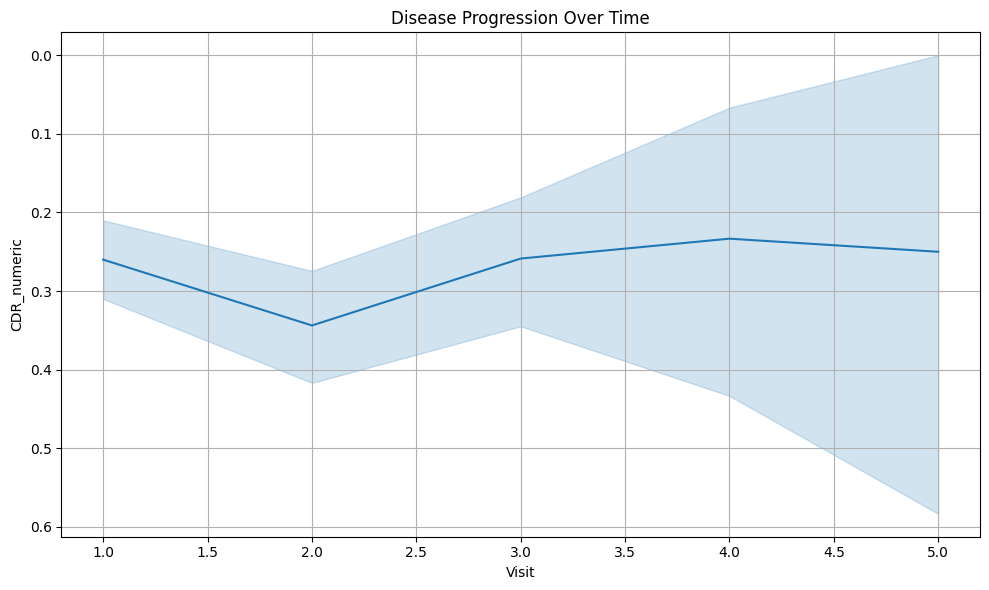

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, x='visit', y='CDR_numeric')
plt.title('Disease Progression Over Time')
plt.xlabel('Visit')
plt.ylabel('CDR_numeric')
plt.grid(True)
plt.tight_layout()
plt.show

In [18]:
#dropping the data for visits past 1 to ensure my data limited to the first visit 
df_final = df_final[df_final["visit"] == 1]

In [14]:
rng = np.random.RandomState(31)
cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)  

In [15]:
x = df_final.drop(columns=["ID", "MRI_ID", "hand", "visit", "delay", "CDR", "worsened"])
y = df_final["worsened"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, stratify=y)

In [22]:
scaler = StandardScaler()
# Delete everything below for student version except data_train_scaled, data_test_scaled = 
scaler.fit(x_train)
data_train_scaled = scaler.transform(x_train)
data_test_scaled = scaler.transform(x_test)

In [17]:
def prepare_data(df_final: pd.DataFrame):
    df_final = df_final[df_final["visit"] == 1] 
    x = df_final.drop(columns=["ID", "MRI_ID", "hand", "visit", "delay", "CDR", "worsened"])
    y = df_final["worsened"]
    return x, y

def logisitic_regression_manual_scaling_cv(x, y, cv: StratifiedKFold, rng):
    accuracy_scores = []
    f1_scores = []
    for train_index, val_index in cv.split(x, y):
        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        scaler = StandardScaler()
        scaler.fit(x_train) 
        x_train_scaled = scaler.transform(x_train)
        x_val_scaled = scaler.transform(x_val)
        lr = LogisticRegression(solver='lbfgs', random_state=rng, max_iter=1000, C=1.0, penalty=None)
        lr.fit(x_train_scaled, y_train)
        y_pred_val = lr.predict(x_val_scaled)
        fold_accuracy = accuracy_score(y_val, y_pred_val)
        fold_f1 = f1_score(y_val, y_pred_val)
        accuracy_scores.append(fold_accuracy)
        f1_scores.append(fold_f1)
    
    # 2. Calculate final summary statistics
    cv_accuracy_mean = np.mean(accuracy_scores)
    cv_accuracy_std = np.std(accuracy_scores)
    cv_f1_mean = np.mean(f1_scores)
    cv_f1_std = np.std(f1_scores)
    
    # --- Return Results ---
    return {
        'cv_mean_accuracy': cv_accuracy_mean,
        'cv_std_accuracy': cv_accuracy_std,
        'cv_mean_f1': cv_f1_mean,
        'cv_std_f1': cv_f1_std,
    }

x, y = prepare_data(df_final)
results = logisitic_regression_manual_scaling_cv(x, y, cv, rng)
results


{'cv_mean_accuracy': np.float64(0.7733333333333332),
 'cv_std_accuracy': np.float64(0.024944382578492973),
 'cv_mean_f1': np.float64(0.0),
 'cv_std_f1': np.float64(0.0)}

In [23]:
lr = LogisticRegression(solver='lbfgs', random_state=42, max_iter=1000, C=1.0, penalty=None)
lr.fit(data_train_scaled, y_train)
y_pred = lr.predict(data_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
n = len(y_test)
ci = 1.96 * np.sqrt((accuracy * (1 - accuracy)) / n)
f1_score = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"95% CI: {accuracy - ci:.2f} - {accuracy + ci:.2f}")
print(f"F1-Score: {f1_score:.2f}")

Accuracy: 0.80
95% CI: 0.68 - 0.92
F1-Score: 0.00


In [24]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
recall_worsened = report['1']['recall']
precision_worsened = report['1']['precision']
f1_worsened = report['1']['f1-score']

print("\n--- Detailed Minority Class (Worsened = 1) Metrics ---")
print(f"Recall: {recall_worsened:.4f} (Crucial for imbalanced data)")
print(f"Precision: {precision_worsened:.4f}")
print(f"F1-Score: {f1_worsened:.4f}")


--- Detailed Minority Class (Worsened = 1) Metrics ---
Recall: 0.0000 (Crucial for imbalanced data)
Precision: 0.0000
F1-Score: 0.0000


Text(70.72222222222221, 0.5, 'Actual')

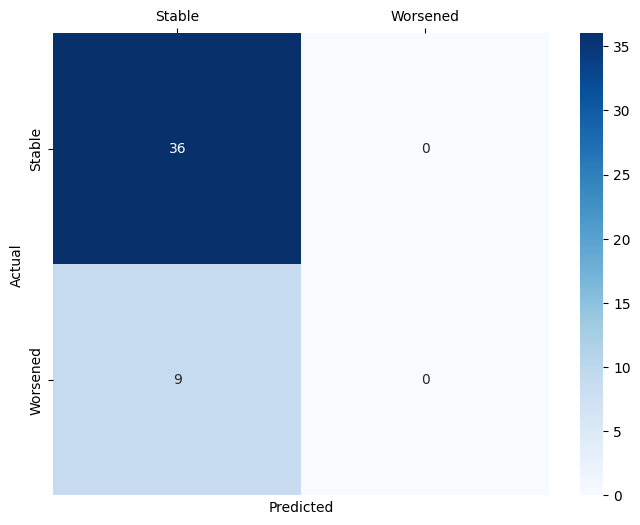

In [25]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
display_labels = ['Stable', 'Worsened']
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=display_labels,
    yticklabels=display_labels,
    cbar=True, 
    ax=ax)#)
ax.xaxis.tick_top()
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [26]:
results = []

# Define the penalties and their required solvers
penalties_config = [
    # L2 is standard and often a good default
    {'penalty': 'l2', 'solver': 'lbfgs', 'name': 'L2 (Ridge)'},
    
    # L1 promotes sparsity (selects features). Requires 'liblinear' or 'saga' solver.
    {'penalty': 'l1', 'solver': 'liblinear', 'name': 'L1 (Lasso)'}
]

print("--- Logistic Regression Regularization Comparison ---")

for config in penalties_config:
    penalty = config['penalty']
    solver = config['solver']
    name = config['name']

    # 1. Initialize the model with the specified penalty and solver
    lr = LogisticRegression(
        solver=solver, 
        penalty=penalty, 
        C=1.0, 
        random_state=42, 
        max_iter=1000
    )

    # 2. Train the model on the SCALED, RESAMPLED training data
    # FIX: Use y_resampled for the targets
    lr.fit(data_train_scaled, y_train)
    
    # 3. Predict using the SCALED test data
    # FIX: Use data_test_scaled for consistent prediction
    y_pred = lr.predict(data_test_scaled)
    
    # 4. Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    n = len(y_test)
    
    # Calculate 95% Confidence Interval (Normal Approximation)
    ci_half_width = 1.96 * np.sqrt((accuracy * (1 - accuracy)) / n)
    ci_lower = accuracy - ci_half_width
    ci_upper = accuracy + ci_half_width
    
    results.append({
        'Penalty': name,
        'Accuracy': f"{accuracy:.4f}",
        'CI_Lower': f"{ci_lower:.4f}",
        'CI_Upper': f"{ci_upper:.4f}"
    })

    print(f"\nModel: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"95% CI: {ci_lower:.4f} - {ci_upper:.4f}")
    
# Optional: Print results in a neat table
print("\n--- Summary Table ---")
for r in results:
    print(f"| {r['Penalty']:<15} | Acc: {r['Accuracy']} | 95% CI: {r['CI_Lower']} - {r['CI_Upper']} |")

--- Logistic Regression Regularization Comparison ---

Model: L2 (Ridge)
Accuracy: 0.8000
95% CI: 0.6831 - 0.9169

Model: L1 (Lasso)
Accuracy: 0.8000
95% CI: 0.6831 - 0.9169

--- Summary Table ---
| L2 (Ridge)      | Acc: 0.8000 | 95% CI: 0.6831 - 0.9169 |
| L1 (Lasso)      | Acc: 0.8000 | 95% CI: 0.6831 - 0.9169 |
